# Практика 11.1. Одновимірна оптимізація
Корешков

```
 - Обчислити методом золотого перерізу найменше або найбільше значення
функції f (x) на відрізку [a; b]. Точку x, в якій функція приймає це
значення, визначити з точністю до epsilon < 0,01
1) Корешков Михайло   f(x)=x^2/3+x*(ln(x)-1); [0.5;1]; f_min=?
```

## Теорія

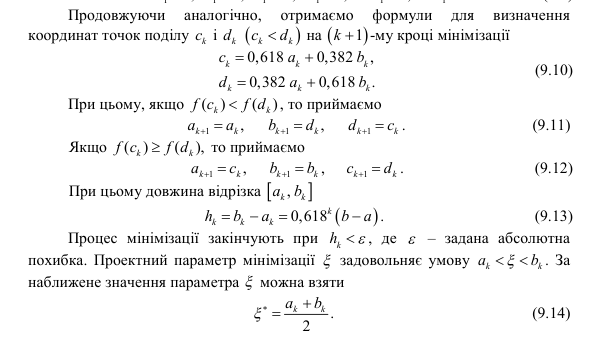

## Резалізація

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sympy as sym

def f(x):
    return (x**2)/3 + x*(np.log(x)-1)

def sym_f(x):
    return (x**2)/3 + x*(sym.log(x)-1)

EPS = 0.01
xlims = 0.5, 1

### Візуалізація золотого перерізу

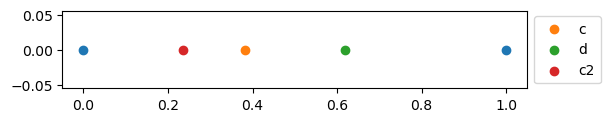

In [2]:
a, b = 0, 1
c = 0.618*a + 0.382*b
d = 0.382*a + 0.618*b
c2 = 0.618*a + 0.382*d
plt.scatter([a,b], [0,0])
plt.scatter([c], [0], label='c')
plt.scatter([d], [0], label='d')
plt.scatter([c2], [0], label='c2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.gcf().set_size_inches(6,1)

In [3]:
# Golden Ratio optimizer
def gr_opt(f, xlims, eps=EPS, timeout=100):
    a, b = xlims
    c = 0.618*a + 0.382*b
    d = 0.382*a + 0.618*b
    fc, fd = f(c), f(d)
    
    '''
    a            [с]      d            b
    [             |       |            ]
    a        c   [d]      b
    [        |    |       ]
             a    c  d    b
             [    |  |    ]
    '''

    print(f"Initial state:   a{a:.5g}   c{c:.5g}   d{d:.5g}   b{b:.5g}")

    points_hist = [a, b, c, d]
    points_step = [0, 0, 0, 0]

    steps = 0
    while steps < timeout:
        a0, b0, c0, d0 = a, b, c, d
        if fc < fd:
            a = a0
            b = d0
            c = 0.618*a0 + 0.382*d0
            d = c0
            fd = fc
            fc = f(c)
            points_hist.append(c)
            points_step.append(steps)
        else: # if fc > fd
            a = c0
            b = b0
            c = d0
            d = 0.382*c0 + 0.618*b0
            fc = fd
            fd = f(d)
            points_hist.append(d)
            points_step.append(steps)

        print(f"After step {steps}:   a{a:.5g}   c{c:.5g}   d{d:.5g}   b{b:.5g}")
        if (d-c) < eps:
            print("Exiting because of eps")
            break
        steps += 1

    if steps == timeout:
        print("Exited because of timeout!")

    return (d+c) / 2, points_hist, points_step



In [4]:
x0, hist, colors = gr_opt(f, xlims, eps=EPS)
print(f"Optimisation result is {x0}")
print(f"f(x0) = {f(x0)}")

Initial state:   a0.5   c0.691   d0.809   b1
After step 0:   a0.5   c0.61804   d0.691   b0.809
After step 1:   a0.5   c0.57296   d0.61804   b0.691
After step 2:   a0.57296   c0.61804   d0.64591   b0.691
After step 3:   a0.61804   c0.64591   d0.66313   b0.691
After step 4:   a0.61804   c0.63526   d0.64591   b0.66313
After step 5:   a0.63526   c0.64591   d0.65248   b0.66313
Exiting because of eps
Optimisation result is 0.649196605672392
f(x0) = -0.7891768992711548


Text(0.5, 1.0, 'Прогрес оптимізації')

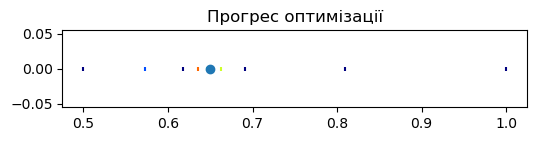

In [5]:
plt.scatter(hist, np.zeros_like(hist), c=colors, s=10, marker='|', cmap='jet')
plt.gcf().set_size_inches(6,1)
plt.scatter([x0], [0])
plt.title("Прогрес оптимізації")

## Оцінка результатів

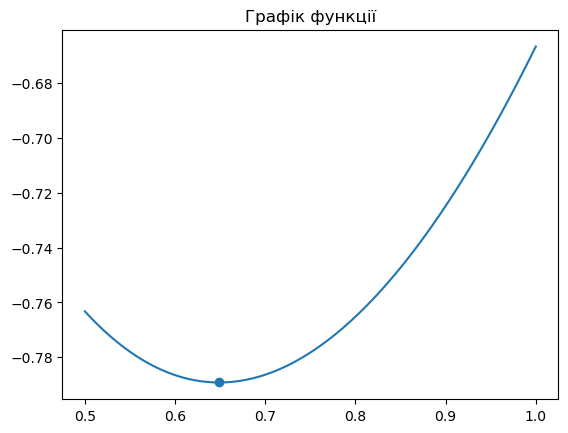

In [6]:
XX = np.linspace(*xlims, 100)
YY = f(XX)

optxx = np.linspace(0.6, 0.7, 1000)
optyy = f(optxx)
true_x = optxx[optyy.argmin()]

plt.plot(XX, YY)
plt.title("Графік функції")
plt.scatter(true_x, f(true_x))

In [7]:
D = x0 - true_x
E = x0/true_x - 1
print(f"Abs X error ~ {D:.3g}")
print(f"Rel X error ~ {E:.3g}")

Abs X error ~ 0.000348
Rel X error ~ 0.000536


# Практика 11.2. Метод найшвидшого спуску

```
- Методом найшвидшого спуску обчислити найменше значення функції f(x)=(A*x,x)/2-(b,x) з точністю epsilon <  0,01, взявши за початкове наближення x^(0). 
A – симетрична додатно визначена матриця третього порядку; 
(x, y) скалярний добуток векторів у тривимірному просторі.
1) Корешков Михайло   A={{3,2,1},{2,5,1},{1,1,7}}; b={{5},{8},{7}}; x^(0)={{0.5},{1.2},{0.8}}
```

In [8]:
A = np.array([
    [3, 2, 1],
    [2, 5, 1],
    [1, 1, 7]
])
b = np.array([5, 8, 7])
start_x = np.array([0.5, 1.2, 0.8])

In [9]:
# the Fastest Quadratic Form Descent
def fdQ_opt(A, b, start_x, eps=0.01, timeout=100):   
    def f(x):
        return x.T @ A @ x / 2 - b.dot(x)

    def df(x):
        return A @ x - b
    
    x = start_x
    fx = f(x)

    print(f"Initial state:   x {x.round(5)}   fx {fx:.5g}")

    xn = [x]
    yn = [fx]

    steps = 0
    while steps < timeout:
        x0, fx0 = x, fx

        dfx = df(x)
        p = dfx.dot(dfx)
        q = dfx.dot(A @ dfx)
        h = p/q
        x = x0 - h * dfx
        fx = f(x)

        xn.append(x)
        yn.append(fx)

        print(f"After step {steps}:   x {x.round(5)}   fx {fx:.5g}   grad {dfx.round(5)}")
        # criterium based on grad 1-norm
        if np.abs(dfx).max() < eps:
            print("Exiting because of eps")
            break
        steps += 1

    if steps == timeout:
        print("Exited because of timeout!")

    return x, xn, yn


In [10]:
x0, xhist, yhist = fdQ_opt(A, b, start_x, EPS)

def f(x):
    return x.T @ A @ x / 2 - b.dot(x)

def df(x):
    return A @ x - b

print(f"Optimisation result is {x0}")
print(f"f(x0) = {f(x0)}")

Initial state:   x [0.5 1.2 0.8]   fx -8.925
After step 0:   x [0.56346 1.24231 0.73654]   fx -8.9483   grad [-0.3 -0.2  0.3]
After step 1:   x [0.59969 1.21159 0.75229]   fx -8.9513   grad [-0.08846  0.075   -0.03846]
After step 2:   x [0.60388 1.21001 0.73957]   fx -8.9519   grad [-0.02545  0.00963  0.07732]
After step 3:   x [0.61052 1.21062 0.74168]   fx -8.952   grad [-0.02878 -0.00264 -0.00915]
After step 4:   x [0.61154 1.2077  0.7393 ]   fx -8.952   grad [-0.00554  0.01579  0.01287]
After step 5:   x [0.61398 1.2075  0.74059]   fx -8.952   grad [-0.01068  0.00087 -0.00567]
After step 6:   x [0.61443 1.20638 0.73955]   fx -8.9521   grad [-0.00248  0.00604  0.00561]
Exiting because of eps
Optimisation result is [0.61443465 1.20638344 0.73955407]
f(x0) = -8.9520500593233


## Візуалізація

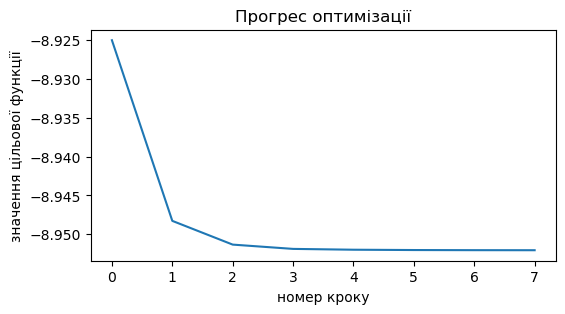

In [11]:
plt.plot(np.arange(len(yhist)), yhist)
plt.title("Прогрес оптимізації")
plt.ylabel('значення цільової функції')
plt.xlabel('номер кроку')
plt.gcf().set_size_inches(6,3)

## Оцінка результатів

In [12]:
sp_ans = sp.optimize.minimize(f, x0=start_x, jac = df, bounds=[(-2,2),(-2,2),(-2,2)])
sp_ans

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -8.95205479452029
        x: [ 6.164e-01  1.205e+00  7.397e-01]
      nit: 6
      jac: [-1.582e-07  1.197e-06  6.394e-07]
     nfev: 8
     njev: 8
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [13]:
D = np.abs(x0-sp_ans.x).max()
print(f"Abs X error ~ {D:.2g}")

Abs X error ~ 0.002
